In [17]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 58.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import joblib

plt.style.use("ggplot")

In [3]:
DATA_PATH = "/content/Metro_Interstate_Traffic_Volume.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,02-10-2012 09:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,02-10-2012 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,02-10-2012 13:00,4918


In [4]:
df.info()
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
holiday,61,11,Labor Day,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,48204.0,NaN,NaN,NaN,281.20587,13.338232,0.0,272.16,282.45,291.806,310.07
rain_1h,48204.0,NaN,NaN,NaN,0.334264,44.789133,0.0,0.0,0.0,0.0,9831.3
snow_1h,48204.0,NaN,NaN,NaN,0.000222,0.008168,0.0,0.0,0.0,0.0,0.51
clouds_all,48204.0,NaN,NaN,NaN,49.362231,39.01575,0.0,1.0,64.0,90.0,100.0
weather_main,48204,11,Clouds,15164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather_description,48204,38,sky is clear,11665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_time,48204,40575,18-04-2013 22:00,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
traffic_volume,48204.0,NaN,NaN,NaN,3259.818355,1986.86067,0.0,1193.0,3380.0,4933.0,7280.0


In [5]:
import pandas as pd
import numpy as np
from dateutil import parser

df_clean = df.copy()

# 1) Basic cleaning of obviously invalid numeric values (your existing steps)
df_clean = df_clean[df_clean["temp"] > 0]
df_clean = df_clean[df_clean["rain_1h"] < 60]
df_clean = df_clean[df_clean["snow_1h"] < 60]

# 2) Strip whitespace and replace weird non-breaking spaces, just in case
df_clean['date_time'] = df_clean['date_time'].astype(str).str.strip().str.replace('\u00A0', ' ')

# 3) Try parsing with dayfirst — this will handle "13-10-2012 00:00" correctly
df_clean['date_time_parsed'] = pd.to_datetime(
    df_clean['date_time'],
    dayfirst=True,              # important for day-month-year strings like 13-10-2012
    infer_datetime_format=True, # speeds up and helps when formats are consistent
    errors='coerce'             # parsing failures become NaT instead of raising
)

# 4) Check if any rows failed to parse
failed = df_clean[df_clean['date_time_parsed'].isna()]
print(f"Failed to parse {len(failed)} rows")

# 5) If there are failures, inspect a few examples to see patterns
if len(failed) > 0:
    print(failed['date_time'].head(20).to_list())

    # Optional: try a best-effort parser using dateutil for the failed rows
    def try_dateutil(x):
        try:
            # parser.parse with dayfirst=True catches many odd formats
            return parser.parse(x, dayfirst=True)
        except Exception:
            return pd.NaT

    df_clean.loc[failed.index, 'date_time_parsed'] = failed['date_time'].apply(try_dateutil)

# 6) Final check and drop/raise if any still missing
still_failed = df_clean['date_time_parsed'].isna().sum()
if still_failed:
    print(f"Still {still_failed} unparsed rows. You can inspect them with df_clean[df_clean['date_time_parsed'].isna()]")
else:
    print("All dates parsed successfully.")

# 7) Replace original column (or keep parsed column) and extract features
df_clean['date_time'] = df_clean['date_time_parsed']
df_clean = df_clean.drop(columns=['date_time_parsed'])

# Now safe to extract components
df_clean['hour'] = df_clean['date_time'].dt.hour
df_clean['month'] = df_clean['date_time'].dt.month
df_clean['dayofweek'] = df_clean['date_time'].dt.dayofweek
df_clean['year'] = df_clean['date_time'].dt.year
df_clean['date_time_parsed'] = pd.to_datetime(
    df_clean['date_time'],
    dayfirst=True,
    errors='coerce'
)


Failed to parse 0 rows
All dates parsed successfully.


/tmp/ipython-input-1477876046.py:16: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_clean['date_time_parsed'] = pd.to_datetime(


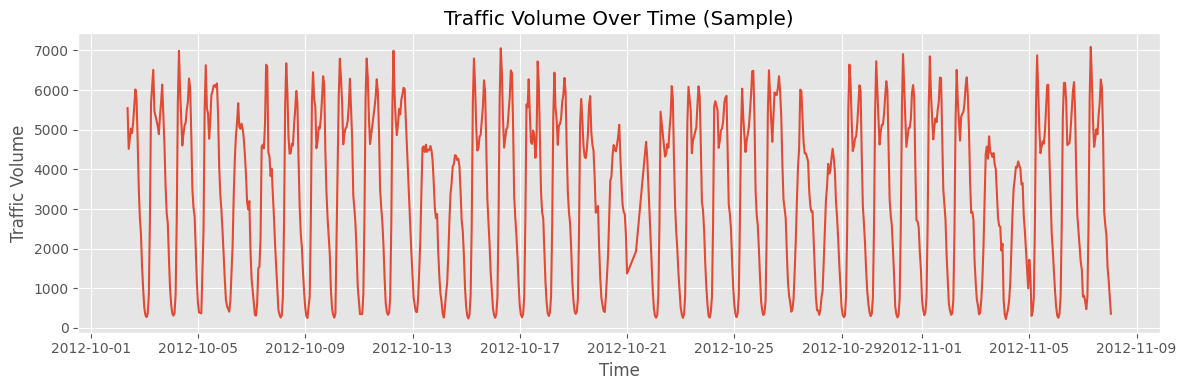

In [6]:
sample = df_clean.iloc[:1000]  # first 1000 rows for clarity

plt.figure(figsize=(12, 4))
plt.plot(sample["date_time"], sample["traffic_volume"])
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume Over Time (Sample)")
plt.tight_layout()
plt.show()

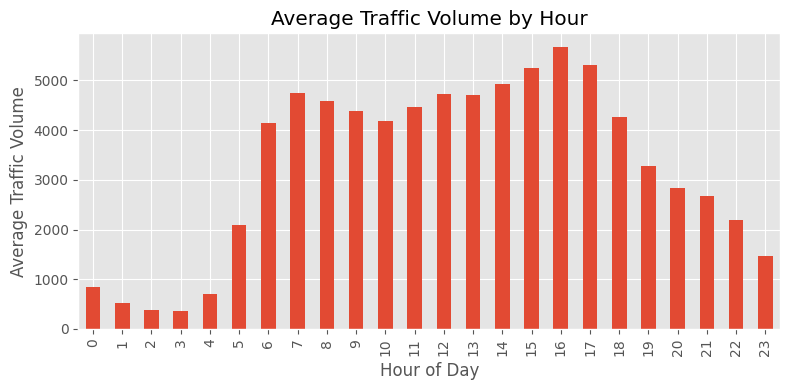

In [7]:
hourly = df_clean.groupby("hour")["traffic_volume"].mean()

plt.figure(figsize=(8, 4))
hourly.plot(kind="bar")
plt.xlabel("Hour of Day")
plt.ylabel("Average Traffic Volume")
plt.title("Average Traffic Volume by Hour")
plt.tight_layout()
plt.show()

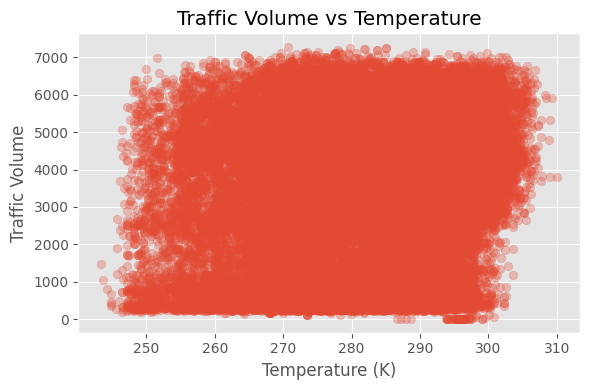

In [8]:
plt.figure(figsize=(6, 4))
plt.scatter(df_clean["temp"], df_clean["traffic_volume"], alpha=0.3)
plt.xlabel("Temperature (K)")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume vs Temperature")
plt.tight_layout()
plt.show()

In [9]:
target = "traffic_volume"

numeric_features = ["temp", "rain_1h", "snow_1h", "clouds_all", "hour", "month", "dayofweek", "year"]
categorical_features = ["holiday", "weather_main"]

X = df_clean[numeric_features + categorical_features]
y = df_clean[target]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

len(X_train), len(X_test)

(38554, 9639)

In [11]:
numeric_transformer = "passthrough"

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("rf", rf),
    ]
)

model

,steps,"[('preprocess', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

MAE:  308.70
RMSE: 536.94
R²:   0.926


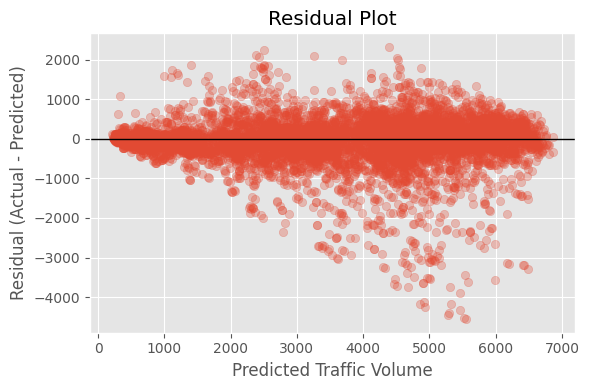

In [15]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Predicted Traffic Volume")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

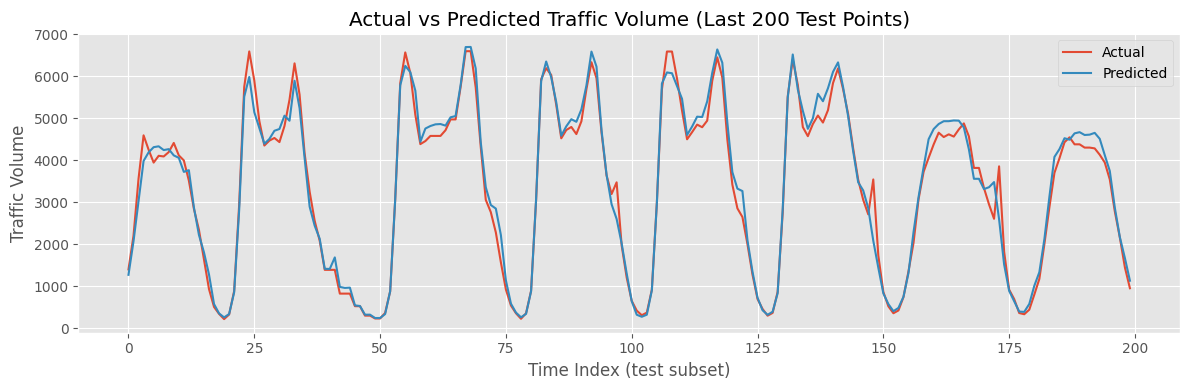

In [16]:
N = 200
plt.figure(figsize=(12, 4))
plt.plot(y_test.values[-N:], label="Actual")
plt.plot(y_pred[-N:], label="Predicted")
plt.xlabel("Time Index (test subset)")
plt.ylabel("Traffic Volume")
plt.title("Actual vs Predicted Traffic Volume (Last 200 Test Points)")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
joblib.dump(model, "/content/rf_traffic_model.pkl")

print("Model saved")

Model saved


In [19]:
meta = {
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
}
joblib.dump(meta, "/content/feature_meta.pkl")

['/content/feature_meta.pkl']